# List 3

In [1]:
from platform import python_version
from googleapiclient.discovery import build
import re
from datetime import time, timedelta, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import pandas as pd

sns.set_style('whitegrid');

In [2]:
plt.rcParams['figure.figsize'] = [16, 9]  # changing parameters for presented plots
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

## Table of contents
<br>

1. [Channels data preparations](#Channels_data_preparations)     
    1.1. [Basic information about both channels](#Basic_information_about_both_channels)    
    1.2. [Preparation of the main Data Frames](#Preparation_of_the_main_Data_Frames)    
2. [Analysis of the content](#Analysis_of_the_content)    
    2.1. [The quality of the uploaded videos.](#The_quality_of_the_uploaded_videos.)    
    2.2. [Captions](#How_much_videos_contains_captions)    
    2.3. [Views, likes, dislikes and comment analysis](#Views_likes_dislikes_and_comment_analysis)    
    2.4. [Compare the tags of both videos](#Compare_the_tags_of_both_videos)
3. [Summary](#Summary)

## Channels data preparations

In [1]:
with open('my_api_key.txt') as f:
    api = f.readlines()

In [4]:
youtube = build('youtube','v3',developerKey=api[0])

In [5]:
UNB_stats = youtube.channels().list(part="statistics",id="UC_7PqixGIdE-jjoHKMPYpGA").execute()
K_stats = youtube.channels().list(part="statistics",id="UCsXVk37bltHxD1rDPwtNM8Q").execute()

In [6]:
UNB_snippet = youtube.channels().list(part="snippet",id="UC_7PqixGIdE-jjoHKMPYpGA").execute()
K_snippet = youtube.channels().list(part="snippet",id="UCsXVk37bltHxD1rDPwtNM8Q").execute()

## Basic_information_about_both_channels

In [7]:
info = """
        Channel name: {}\n
        Channel ID: {}\n
        Short official description:\n\n {}\n
        Founding date: {}\n
        Homeland of the creators: {} - Poland\n
        Number of Subscribers: {}\n
        Number of views: {}\n
        Number of videos: {}
        """.format((UNB_snippet['items'])[0]['snippet']['title'],
                    (UNB_snippet['items'])[0]['id'],
                    (UNB_snippet['items'])[0]['snippet']['description'],
                    (UNB_snippet['items'])[0]['snippet']['publishedAt'],
                    (UNB_snippet['items'])[0]['snippet']['country'],
                    (UNB_stats['items'])[0]['statistics']['subscriberCount'],
                    (UNB_stats['items'])[0]['statistics']['viewCount'],
                    (UNB_stats['items'])[0]['statistics']['videoCount']                   
                    )
print(info)


        Channel name: Uwaga! Naukowy Bełkot

        Channel ID: UC_7PqixGIdE-jjoHKMPYpGA

        Short official description:

 Czy wiesz, że 63% osób jest w stanie uwierzyć w nieprawdziwą informację, jeśli jest w niej odwołanie do badań i statystyk? Nie musisz jednak nic wymyślać - nauka jest bowiem pełna wiedzy, która szokuje i ciekawi. Jeśli chcesz błyszczeć takimi faktami wśród znajomych to jesteś w dobrym miejscu ;-).

Adresy e-mail:
UwagaNaukowyBelkot@gmail.com
UwagaNaukowyBelkot@lifetube.pl

        Founding date: 2014-11-24T15:35:02Z

        Homeland of the creators: PL - Poland

        Number of Subscribers: 656000

        Number of views: 88196085

        Number of videos: 319
        


### Uwaga! Naukowy Bełkot 
(https://www.youtube.com/channel/UC_7PqixGIdE-jjoHKMPYpGA)
UNB is a polish channel focused on science, with particular emphasis on chemistry, physics and genetics. Popular science channel that searches for the truth about the world around us.Knowledge is communicated in an accessible but more complex way than in the case of our second channel.

In [8]:
info = """
        Channel name: {}\n
        Channel ID: {}\n
        Short official description:\n\n {}\n
        Founding date: {}\n
        Homeland of the creators: {} - Germany\n
        Number of Subscribers: {}\n
        Number of views: {}\n
        Number of videos: {}
        """.format((K_snippet['items'])[0]['snippet']['title'],
                    (K_snippet['items'])[0]['id'],
                    (K_snippet['items'])[0]['snippet']['description'],
                    (K_snippet['items'])[0]['snippet']['publishedAt'],
                    (K_snippet['items'])[0]['snippet']['country'],
                    (K_stats['items'])[0]['statistics']['subscriberCount'],
                    (K_stats['items'])[0]['statistics']['viewCount'],
                    (K_stats['items'])[0]['statistics']['videoCount']                   
                    )
print(info)


        Channel name: Kurzgesagt – In a Nutshell

        Channel ID: UCsXVk37bltHxD1rDPwtNM8Q

        Short official description:

 Videos explaining things with optimistic nihilism. 

We are a small team who want to make science look beautiful. Because it is beautiful. 

Currently we make one animation video per month. Follow us on Twitter, Facebook to get notified when a new one comes out.

FAQ:
 
- We do the videos with After Effects and Illustrator.

        Founding date: 2013-07-09T20:17:20Z

        Homeland of the creators: DE - Germany

        Number of Subscribers: 16900000

        Number of views: 1680710861

        Number of videos: 150
        


### Kurzgesagt – In a Nutshell
(https://www.youtube.com/channel/UCsXVk37bltHxD1rDPwtNM8Q) 
Kurzgesagt – In a Nutshell is a German YouTube channel that produces educational animation videos that attempt to explain complex topics in some depth, but in a format that is accessible to non-specialist audiences.

## Preparation_of_the_main_Data_Frames

In [9]:
UNB_content = youtube.channels().list(part="contentDetails",id="UC_7PqixGIdE-jjoHKMPYpGA").execute()
K_content = youtube.channels().list(part="contentDetails",id="UCsXVk37bltHxD1rDPwtNM8Q").execute()

In [10]:
UNB_UploadId=UNB_content["items"][0]["contentDetails"]["relatedPlaylists"]["uploads"]
K_UploadId=K_content["items"][0]["contentDetails"]["relatedPlaylists"]["uploads"]

In [11]:
UNB_allVideos=[]
K_allVideos=[]
nextPage_token=None

In [12]:
while 1:
    UNB_res = youtube.playlistItems().list(playlistId=UNB_UploadId,maxResults=50,part="snippet",pageToken=nextPage_token).execute()
    UNB_allVideos +=UNB_res["items"]
    nextPage_token = UNB_res.get("nextPageToken")
    if nextPage_token is None:
        break

nextPage_token=None
while 1:
    K_res = youtube.playlistItems().list(playlistId=K_UploadId,maxResults=50,part="snippet",pageToken=nextPage_token).execute()
    K_allVideos +=K_res["items"]
    nextPage_token = K_res.get("nextPageToken")
    if nextPage_token is None:
        break

In [13]:
UNB_allVideosContentDetails = []
K_allVideosContentDetails = []
while 1:
    UNB_res = youtube.playlistItems().list(playlistId=UNB_UploadId,maxResults=50,part="contentDetails",pageToken=nextPage_token).execute()
    UNB_allVideosContentDetails +=UNB_res["items"]
    nextPage_token = UNB_res.get("nextPageToken")
    if nextPage_token is None:
        break
nextPage_token=None        

while 1:
    K_res = youtube.playlistItems().list(playlistId=K_UploadId,maxResults=50,part="contentDetails",pageToken=nextPage_token).execute()
    K_allVideosContentDetails +=K_res["items"]
    nextPage_token = K_res.get("nextPageToken")
    if nextPage_token is None:
        break

In [14]:
UNB_video_ids = list(map(lambda x:x["snippet"]["resourceId"]["videoId"],UNB_allVideos))
K_video_ids = list(map(lambda x:x["snippet"]["resourceId"]["videoId"],K_allVideos))

In [15]:
UNB_statsAndContentDetails = []
K_statsAndContentDetails = []

for videoid in UNB_video_ids:
    res=youtube.videos().list(id=videoid,part="statistics,contentDetails").execute()
    UNB_statsAndContentDetails+=res["items"]
    
for videoid in K_video_ids:
    res=youtube.videos().list(id=videoid,part="statistics,contentDetails").execute()
    K_statsAndContentDetails+=res["items"]

In [16]:
UNB_title = []
UNB_liked =[]
UNB_disliked =[]
UNB_views =[]
UNB_url =[]
UNB_comment =[]
UNB_videoid =[]
UNB_publishedDate=[]
UNB_video_description=[]
UNB_video_durationInit = []
UNB_video_definition=[]
UNB_video_caption=[]

K_title = []
K_liked =[]
K_disliked =[]
K_views =[]
K_url =[]
K_comment =[]
K_videoid =[]
K_publishedDate=[]
K_video_description=[]
K_video_durationInit = []
K_video_definition=[]
K_video_caption=[]

In [17]:
for i in range(len(UNB_video_ids)):
    UNB_title.append((UNB_allVideos[i])["snippet"]["title"])
    UNB_publishedDate.append((UNB_allVideos[i])["snippet"]["publishedAt"])
    UNB_video_description.append((UNB_allVideos[i])["snippet"]["description"])
    UNB_liked.append((UNB_statsAndContentDetails[i])["statistics"]["likeCount"])
    UNB_disliked.append((UNB_statsAndContentDetails[i])["statistics"]["dislikeCount"])
    UNB_views.append((UNB_statsAndContentDetails[i])["statistics"]["viewCount"])
    UNB_comment.append((UNB_statsAndContentDetails[i])["statistics"]["commentCount"])
    UNB_videoid.append((UNB_allVideos[i])["snippet"]["resourceId"]["videoId"])
    UNB_video_durationInit.append((UNB_statsAndContentDetails[i])["contentDetails"]['duration'])
    UNB_video_definition.append((UNB_statsAndContentDetails[i])["contentDetails"]['definition'])
    UNB_video_caption.append((UNB_statsAndContentDetails[i])["contentDetails"]['caption'])
    
for i in range(len(K_video_ids)):
    K_title.append((K_allVideos[i])["snippet"]["title"])
    K_publishedDate.append((K_allVideos[i])["snippet"]["publishedAt"])
    K_video_description.append((K_allVideos[i])["snippet"]["description"])
    K_liked.append((K_statsAndContentDetails[i])["statistics"]["likeCount"])
    K_disliked.append((K_statsAndContentDetails[i])["statistics"]["dislikeCount"])
    K_views.append((K_statsAndContentDetails[i])["statistics"]["viewCount"])
    K_comment.append((K_statsAndContentDetails[i])["statistics"]["commentCount"])
    K_videoid.append((K_allVideos[i])["snippet"]["resourceId"]["videoId"])
    K_video_durationInit.append((K_statsAndContentDetails[i])["contentDetails"]['duration'])
    K_video_definition.append((K_statsAndContentDetails[i])["contentDetails"]['definition'])
    K_video_caption.append((K_statsAndContentDetails[i])["contentDetails"]['caption'])

In [18]:
hours_pattern = re.compile(r'(\d+)H')
minutes_pattern = re.compile(r'(\d+)M')
seconds_pattern = re.compile(r'(\d+)S')

In [19]:
UNB_video_duration = []
UNB_video_durationInSec = []

K_video_duration = []
K_video_durationInSec = []


for item in UNB_statsAndContentDetails:
    duration = item['contentDetails']['duration']

    hours = hours_pattern.search(duration)
    minutes = minutes_pattern.search(duration)
    seconds = seconds_pattern.search(duration)

    hours = int(hours.group(1)) if hours else 0
    minutes = int(minutes.group(1)) if minutes else 0
    seconds = int(seconds.group(1)) if seconds else 0

    video_seconds = timedelta(
        hours=hours,
        minutes=minutes,
        seconds=seconds
    ).total_seconds()
    
    video_time = time(
        hour=hours,
        minute=minutes,
        second=seconds
    )
    
    UNB_video_duration.append(video_time)
    UNB_video_durationInSec.append(video_seconds)
    
for item in K_statsAndContentDetails:
    duration = item['contentDetails']['duration']

    hours = hours_pattern.search(duration)
    minutes = minutes_pattern.search(duration)
    seconds = seconds_pattern.search(duration)

    hours = int(hours.group(1)) if hours else 0
    minutes = int(minutes.group(1)) if minutes else 0
    seconds = int(seconds.group(1)) if seconds else 0

    video_seconds = timedelta(
        hours=hours,
        minutes=minutes,
        seconds=seconds
    ).total_seconds()
    
    video_time = time(
        hour=hours,
        minute=minutes,
        second=seconds
    )
    
    K_video_duration.append(video_time)
    K_video_durationInSec.append(video_seconds)

In [20]:
UNB_data={"title":UNB_title,
      "liked":UNB_liked,
      "disliked":UNB_disliked,
      "views":UNB_views,
      "comment":UNB_comment,
      "videoid":UNB_videoid,
      "publishedDate":UNB_publishedDate,
      "video_description":UNB_video_description,
      "duration": UNB_video_duration,
      "duration_in_sec": UNB_video_durationInSec,
      "video_definition": UNB_video_definition,
      "is_caption": UNB_video_caption}

K_data={"title":K_title,
      "liked":K_liked,
      "disliked":K_disliked,
      "views":K_views,
      "comment":K_comment,
      "videoid":K_videoid,
      "publishedDate":K_publishedDate,
      "video_description":K_video_description,
      "duration": K_video_duration,
      "duration_in_sec": K_video_durationInSec,
      "video_definition": K_video_definition,
      "is_caption": K_video_caption}

In [21]:
UNB_df=pd.DataFrame(UNB_data)
K_df=pd.DataFrame(K_data)

In [22]:
UNB_df

,title,liked,disliked,views,comment,videoid,publishedDate,video_description,duration,duration_in_sec,video_definition,is_caption
0,"To zwierzę to prawdziwy ""hardkor nad hardkorami""",9764,178,153472,516,XEWiylscz8c,2021-10-25T11:58:20Z,👉 Tu kupisz bluzy ► https://naukowybelkot.pl/s...,00:12:36,756.0,hd,false
1,Powstał naukowybelkot.pl!,2534,51,50154,167,FSQ2hv_8nOU,2021-10-21T16:35:07Z,👉 https://naukowybelkot.pl\n👉 http://ratstudio...,00:28:46,1726.0,hd,false
2,Tak się robi dinozaury!,6430,46,86868,373,MbTx08Zry_8,2021-10-17T10:13:07Z,👉 Patronite ► https://patronite.pl/NaukowyBelk...,00:33:20,2000.0,hd,false
3,Śmierć na dnie Bałtyku?,21803,278,497326,1133,K9U1-_JD9BM,2021-10-09T15:12:51Z,👉 Patronite ► https://patronite.pl/NaukowyBelk...,01:41:14,6074.0,hd,false
4,Jak zabrać ze sobą prąd?,4346,276,95342,546,k2Z7OCtXndI,2021-09-30T16:19:49Z,👉 Patronite ► https://patronite.pl/NaukowyBelk...,00:19:10,1150.0,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...
314,Steroidy (sterydy) | Słowo na sobotę #5,10037,400,628280,463,2EkpKuiCm3M,2014-12-13T08:56:57Z,zapraszamy na fanpage: \nhttps://www.facebook....,00:11:25,685.0,hd,false
315,Ebola | Słowo na sobotę #4,3184,28,133971,146,kyBjFxvGGaM,2014-12-05T23:59:39Z,Ludzie są mistrzami w konstruowaniu katastrofi...,00:06:56,416.0,hd,false
316,Miodożer (Ratel) | Słowo na sobotę #3,5862,88,217695,211,mnr58R1c1jg,2014-11-29T11:54:31Z,"Dziś słowem na sobotę jest prawdziwy ""hardkor""...",00:06:47,407.0,hd,false
317,Tetrahydrokannabinol | Słowo na sobotę #2,5065,86,209456,280,m7BLVYG665Q,2014-11-29T11:39:12Z,Film opublikowany 22 listopada na kanale AZS ...,00:07:13,433.0,hd,false


In [23]:
K_df

,title,liked,disliked,views,comment,videoid,publishedDate,video_description,duration,duration_in_sec,video_definition,is_caption
0,You Are Immune Against Every Disease,376836,3876,6932319,19859,LmpuerlbJu0,2021-10-29T13:16:12Z,Order IMMUNE here: https://kgs.link/ImmuneBook...,00:11:46,706.0,hd,true
1,The Limited Edition Dinosaur Calendar – Now An...,32781,398,561324,1590,Nv4Nk4AAgk8,2021-10-18T10:26:17Z,"https://kgs.link/12022_Calendar THE 12,022 CAL...",00:01:38,98.0,hd,true
2,What Dinosaurs ACTUALLY Looked Like?,440918,4328,7525131,19312,xaQJbozY_Is,2021-10-12T10:03:46Z,https://kgs.link/12022_Calendar\nAs the year 1...,00:11:41,701.0,hd,true
3,Two Chapters From Our New Book – Exclusive Pre...,77488,906,1653124,4244,0FRVx_c9T0c,2021-09-28T12:45:11Z,To preorder IMMUNE click here: https://kgs.lin...,00:25:56,1556.0,hd,false
4,Can YOU Fix Climate Change?,624009,18074,8606052,64169,yiw6_JakZFc,2021-09-22T11:59:22Z,Sources & further reading:\nhttps://sites.goog...,00:15:50,950.0,hd,true
...,...,...,...,...,...,...,...,...,...,...,...,...
145,How The Stock Exchange Works (For Dummies),124303,2577,7942484,8085,F3QpgXBtDeo,2013-11-28T16:12:35Z,Why are there stocks at all?\n\nEveryday in th...,00:03:34,214.0,hd,true
146,The Gulf Stream Explained,55944,1143,3745182,1912,UuGrBhK2c7U,2013-10-11T18:10:58Z,Learn about the role of the sea in global warm...,00:05:04,304.0,hd,true
147,Fracking explained: opportunity or danger,94062,3440,6869478,8032,Uti2niW2BRA,2013-09-03T09:02:58Z,Fracking explained in five minutes.\n\nFrackin...,00:05:04,304.0,hd,true
148,The Solar System -- our home in space,77351,1124,5613085,6042,KsF_hdjWJjo,2013-08-22T13:17:50Z,An Infographic trip through the wonders of the...,00:07:21,441.0,hd,true


In [24]:
UNB_df.sort_values(by='publishedDate', ascending=True).reset_index(drop=True)

,title,liked,disliked,views,comment,videoid,publishedDate,video_description,duration,duration_in_sec,video_definition,is_caption
0,Argyria | Słowo na sobotę #1,3372,33,96306,65,XjCXT70QMI8,2014-11-29T11:27:42Z,Film opublikowany 15 listopada 2014 jeszcze po...,00:05:51,351.0,hd,false
1,Tetrahydrokannabinol | Słowo na sobotę #2,5065,86,209456,280,m7BLVYG665Q,2014-11-29T11:39:12Z,Film opublikowany 22 listopada na kanale AZS ...,00:07:13,433.0,hd,false
2,Miodożer (Ratel) | Słowo na sobotę #3,5862,88,217695,211,mnr58R1c1jg,2014-11-29T11:54:31Z,"Dziś słowem na sobotę jest prawdziwy ""hardkor""...",00:06:47,407.0,hd,false
3,Ebola | Słowo na sobotę #4,3184,28,133971,146,kyBjFxvGGaM,2014-12-05T23:59:39Z,Ludzie są mistrzami w konstruowaniu katastrofi...,00:06:56,416.0,hd,false
4,Steroidy (sterydy) | Słowo na sobotę #5,10037,400,628280,463,2EkpKuiCm3M,2014-12-13T08:56:57Z,zapraszamy na fanpage: \nhttps://www.facebook....,00:11:25,685.0,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...
314,Jak zabrać ze sobą prąd?,4346,276,95342,546,k2Z7OCtXndI,2021-09-30T16:19:49Z,👉 Patronite ► https://patronite.pl/NaukowyBelk...,00:19:10,1150.0,hd,false
315,Śmierć na dnie Bałtyku?,21803,278,497326,1133,K9U1-_JD9BM,2021-10-09T15:12:51Z,👉 Patronite ► https://patronite.pl/NaukowyBelk...,01:41:14,6074.0,hd,false
316,Tak się robi dinozaury!,6430,46,86868,373,MbTx08Zry_8,2021-10-17T10:13:07Z,👉 Patronite ► https://patronite.pl/NaukowyBelk...,00:33:20,2000.0,hd,false
317,Powstał naukowybelkot.pl!,2534,51,50154,167,FSQ2hv_8nOU,2021-10-21T16:35:07Z,👉 https://naukowybelkot.pl\n👉 http://ratstudio...,00:28:46,1726.0,hd,false


In [25]:
K_df.sort_values(by='publishedDate', ascending=True).reset_index(drop=True)

,title,liked,disliked,views,comment,videoid,publishedDate,video_description,duration,duration_in_sec,video_definition,is_caption
0,How Evolution works,210461,6452,9331298,64739,hOfRN0KihOU,2013-07-11T13:38:44Z,The mechanisms of evolution explained in one v...,00:11:48,708.0,hd,true
1,The Solar System -- our home in space,77351,1124,5613085,6042,KsF_hdjWJjo,2013-08-22T13:17:50Z,An Infographic trip through the wonders of the...,00:07:21,441.0,hd,true
2,Fracking explained: opportunity or danger,94062,3440,6869478,8032,Uti2niW2BRA,2013-09-03T09:02:58Z,Fracking explained in five minutes.\n\nFrackin...,00:05:04,304.0,hd,true
3,The Gulf Stream Explained,55944,1143,3745182,1912,UuGrBhK2c7U,2013-10-11T18:10:58Z,Learn about the role of the sea in global warm...,00:05:04,304.0,hd,true
4,How The Stock Exchange Works (For Dummies),124303,2577,7942484,8085,F3QpgXBtDeo,2013-11-28T16:12:35Z,Why are there stocks at all?\n\nEveryday in th...,00:03:34,214.0,hd,true
...,...,...,...,...,...,...,...,...,...,...,...,...
145,Can YOU Fix Climate Change?,624009,18074,8606052,64169,yiw6_JakZFc,2021-09-22T11:59:22Z,Sources & further reading:\nhttps://sites.goog...,00:15:50,950.0,hd,true
146,Two Chapters From Our New Book – Exclusive Pre...,77488,906,1653124,4244,0FRVx_c9T0c,2021-09-28T12:45:11Z,To preorder IMMUNE click here: https://kgs.lin...,00:25:56,1556.0,hd,false
147,What Dinosaurs ACTUALLY Looked Like?,440918,4328,7525131,19312,xaQJbozY_Is,2021-10-12T10:03:46Z,https://kgs.link/12022_Calendar\nAs the year 1...,00:11:41,701.0,hd,true
148,The Limited Edition Dinosaur Calendar – Now An...,32781,398,561324,1590,Nv4Nk4AAgk8,2021-10-18T10:26:17Z,"https://kgs.link/12022_Calendar THE 12,022 CAL...",00:01:38,98.0,hd,true


In [26]:
UNB_df = UNB_df.astype({"title": str,
                "liked":int,
                "disliked":int,
                "views":int,
                "comment":int,
                "videoid":str,
                "publishedDate": 'datetime64[ns]',
                "video_description":str,
                "video_definition": str,
                "is_caption":str})

K_df = K_df.astype({"title": str,
                "liked":int,
                "disliked":int,
                "views":int,
                "comment":int,
                "videoid":str,
                "publishedDate": 'datetime64[ns]',
                "video_description":str,
                "video_definition": str,
                "is_caption":str})

# Analysis_of_the_content

In [27]:
UNB_views = UNB_df[['title','publishedDate', 'views', 'liked', 'disliked', 'comment', 'duration_in_sec', 'is_caption']]

K_views = K_df[['title','publishedDate', 'views', 'liked', 'disliked', 'comment', 'duration_in_sec', 'is_caption']]

In [28]:
channels = ['Kurzgesagt', 'Uwaga Naukowy Bełkot']

### The_quality_of_the_uploaded_videos.

Both channels uploded their videos in HD.

In [29]:
UNB_quality_set = dict(UNB_df['video_definition'].value_counts())
print(UNB_quality_set) 

K_quality_set = dict(K_df['video_definition'].value_counts())
print(K_quality_set) 

{'hd': 319}
{'hd': 150}


### How_much_videos_contains_captions

In [30]:
UNB_captions_set = dict(UNB_df['is_caption'].value_counts())
K_captions_set = dict(K_df['is_caption'].value_counts())

In [31]:
captions_set = {'haveCaptions':[K_captions_set['true'], UNB_captions_set['true']], 
                'notHaveCaptions':[K_captions_set['false'], UNB_captions_set['false']]}
haveCaptionsCompar = pd.DataFrame(captions_set, index=channels)
haveCaptionsCompar

,haveCaptions,notHaveCaptions
Kurzgesagt,149,1
Uwaga Naukowy Bełkot,24,295


In above table we can see that the majoroty of *Kurzgesagt*'s videos have captions in opposite to *Uwaga Naukowy Bełkot*. We can say that the first channel is more focus on international content than the other. The default language can partially confirmed this conjecture.

In [32]:
UNB_views

,title,publishedDate,views,liked,disliked,comment,duration_in_sec,is_caption
0,"To zwierzę to prawdziwy ""hardkor nad hardkorami""",2021-10-25 11:58:20,153472,9764,178,516,756.0,false
1,Powstał naukowybelkot.pl!,2021-10-21 16:35:07,50154,2534,51,167,1726.0,false
2,Tak się robi dinozaury!,2021-10-17 10:13:07,86868,6430,46,373,2000.0,false
3,Śmierć na dnie Bałtyku?,2021-10-09 15:12:51,497326,21803,278,1133,6074.0,false
4,Jak zabrać ze sobą prąd?,2021-09-30 16:19:49,95342,4346,276,546,1150.0,false
...,...,...,...,...,...,...,...,...
314,Steroidy (sterydy) | Słowo na sobotę #5,2014-12-13 08:56:57,628280,10037,400,463,685.0,false
315,Ebola | Słowo na sobotę #4,2014-12-05 23:59:39,133971,3184,28,146,416.0,false
316,Miodożer (Ratel) | Słowo na sobotę #3,2014-11-29 11:54:31,217695,5862,88,211,407.0,false
317,Tetrahydrokannabinol | Słowo na sobotę #2,2014-11-29 11:39:12,209456,5065,86,280,433.0,false


In [33]:
K_views

,title,publishedDate,views,liked,disliked,comment,duration_in_sec,is_caption
0,You Are Immune Against Every Disease,2021-10-29 13:16:12,6932319,376836,3876,19859,706.0,true
1,The Limited Edition Dinosaur Calendar – Now An...,2021-10-18 10:26:17,561324,32781,398,1590,98.0,true
2,What Dinosaurs ACTUALLY Looked Like?,2021-10-12 10:03:46,7525131,440918,4328,19312,701.0,true
3,Two Chapters From Our New Book – Exclusive Pre...,2021-09-28 12:45:11,1653124,77488,906,4244,1556.0,false
4,Can YOU Fix Climate Change?,2021-09-22 11:59:22,8606052,624009,18074,64169,950.0,true
...,...,...,...,...,...,...,...,...
145,How The Stock Exchange Works (For Dummies),2013-11-28 16:12:35,7942484,124303,2577,8085,214.0,true
146,The Gulf Stream Explained,2013-10-11 18:10:58,3745182,55944,1143,1912,304.0,true
147,Fracking explained: opportunity or danger,2013-09-03 09:02:58,6869478,94062,3440,8032,304.0,true
148,The Solar System -- our home in space,2013-08-22 13:17:50,5613085,77351,1124,6042,441.0,true


## Views_likes_dislikes_and_comment_analysis

<Figure size 1152x648 with 0 Axes>

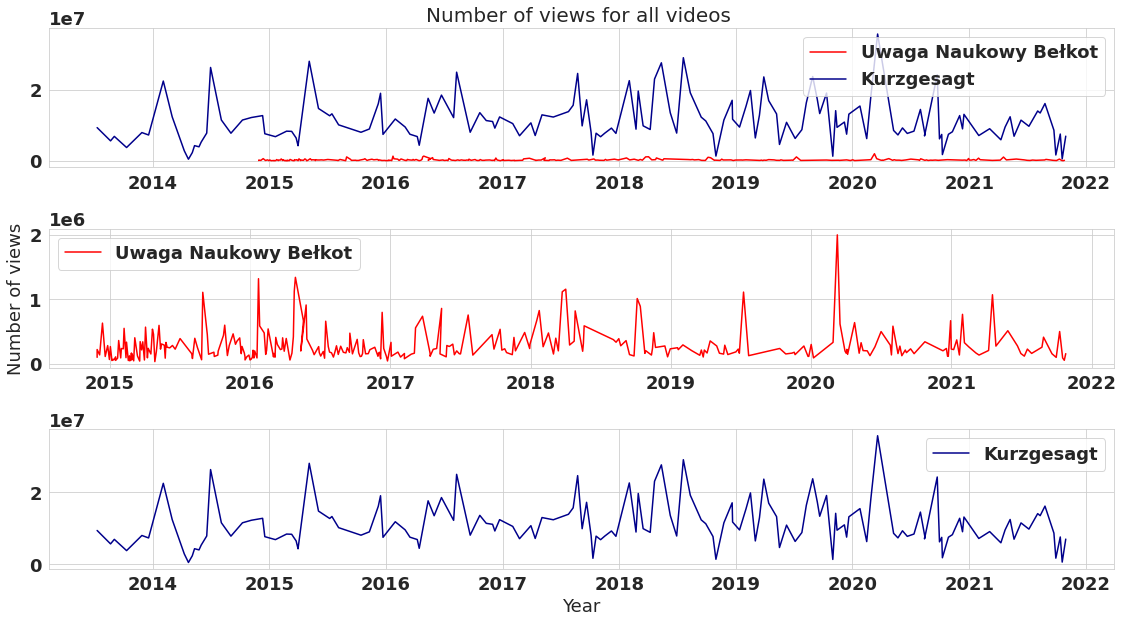

In [34]:
plt.clf()
fig, ax1 = plt.subplots(3,1)


ax1[0].plot(UNB_views['publishedDate'], UNB_views['views'],'r', label = 'Uwaga Naukowy Bełkot')
ax1[0].plot(K_views['publishedDate'], K_views['views'],'darkblue', label = 'Kurzgesagt')
ax1[0].legend(loc=0)
ax1[0].set_title('Number of views for all videos ', fontsize=20)

ax1[1].plot(UNB_views['publishedDate'], UNB_views['views'],'r', label = 'Uwaga Naukowy Bełkot')
ax1[1].legend(loc=0)

ax1[2].plot(K_views['publishedDate'], K_views['views'],'darkblue', label = 'Kurzgesagt')
ax1[2].legend(loc=0)

plt.xlabel("Year")
ax1[1].set_ylabel("Number of views")

fig.tight_layout()

In [35]:
K_maxCommentDate = K_views['publishedDate'][K_views['comment']==K_views['comment'].max()]
UNB_maxCommentDate = UNB_views['publishedDate'][UNB_views['comment']==UNB_views['comment'].max()]

In [36]:
K_maxCommentDate

46   2019-08-29 10:38:28
Name: publishedDate, dtype: datetime64[ns]

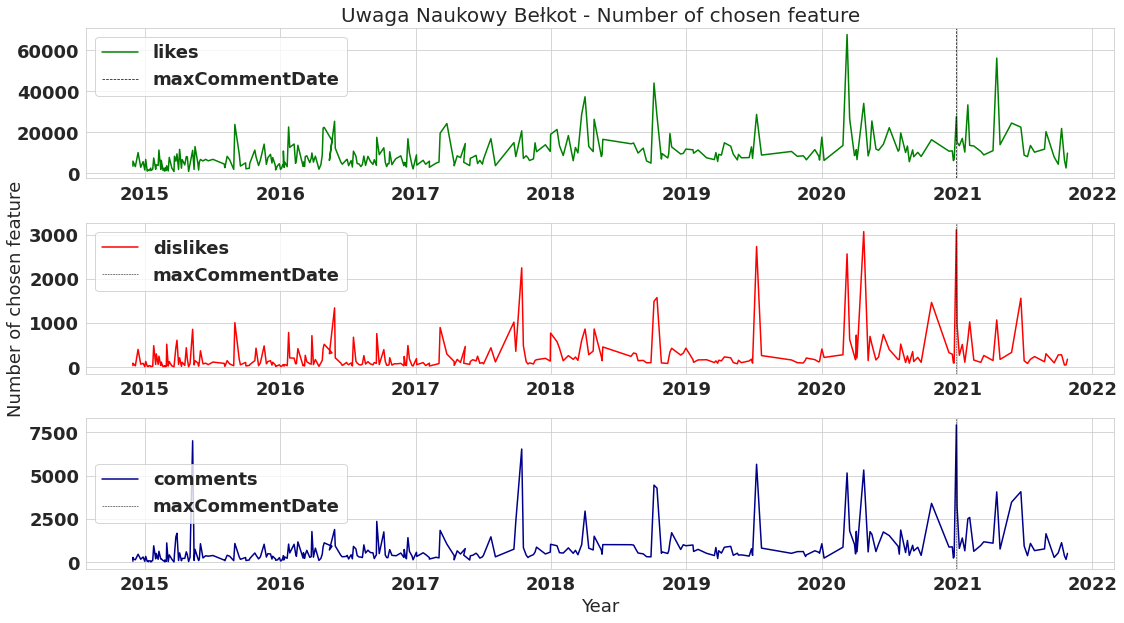

In [37]:
fig, axs = plt.subplots(3, 1)


axs[0].plot(UNB_views['publishedDate'], UNB_views['liked'], label = 'likes', color='green')
axs[0].axvline(UNB_views['publishedDate'][26], color='black', 
               label='maxCommentDate', linestyle='--', linewidth='0.7')
axs[0].set_title('Uwaga Naukowy Bełkot - Number of chosen feature', fontsize=20)
axs[0].legend(loc=0)

axs[1].plot(UNB_views['publishedDate'], UNB_views['disliked'], label = 'dislikes', color='red')
axs[1].axvline(UNB_views['publishedDate'][26], color='black', 
               label='maxCommentDate', linestyle='--', linewidth='0.5')
axs[1].legend(loc=0)

axs[2].plot(UNB_views['publishedDate'], UNB_views['comment'], label = 'comments', color='darkblue')
axs[2].axvline(UNB_views['publishedDate'][26], color='black', 
               label='maxCommentDate', linestyle='--', linewidth='0.5')
axs[2].legend(loc=0)

axs[1].set_ylabel("Number of chosen feature")
plt.xlabel("Year")

plt.tight_layout()

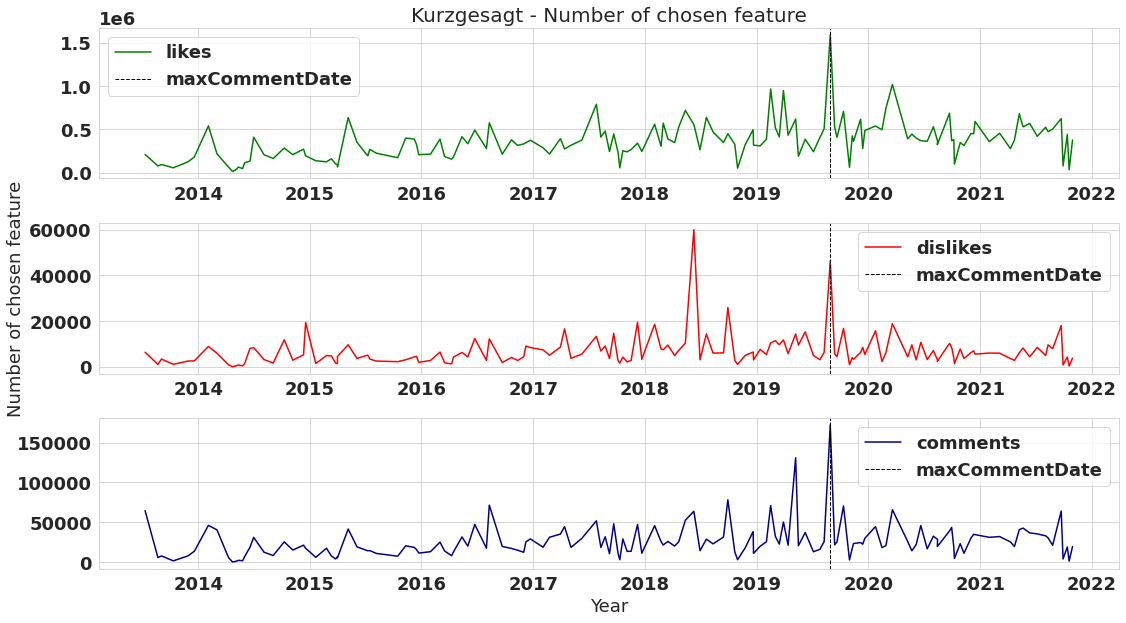

In [38]:
fig, axs = plt.subplots(3, 1)

axs[0].plot(K_views['publishedDate'], K_views['liked'], label = 'likes', color='green')
axs[0].axvline(K_views['publishedDate'][46], color='black', 
               label='maxCommentDate', linestyle='--', linewidth='1')
axs[0].set_title('Kurzgesagt - Number of chosen feature', fontsize=20)
axs[0].legend(loc=0)

axs[1].plot(K_views['publishedDate'], K_views['disliked'], label = 'dislikes', color='red')
axs[1].axvline(K_views['publishedDate'][46], color='black', 
               label='maxCommentDate', linestyle='--', linewidth='1')

axs[1].legend(loc=0)

axs[2].plot(K_views['publishedDate'], K_views['comment'], label = 'comments', color='darkblue')
axs[2].axvline(K_views['publishedDate'][46], color='black', 
               label='maxCommentDate', linestyle='--', linewidth='1')

axs[2].legend(loc=0)

axs[1].set_ylabel("Number of chosen feature")
plt.xlabel("Year")

plt.tight_layout()

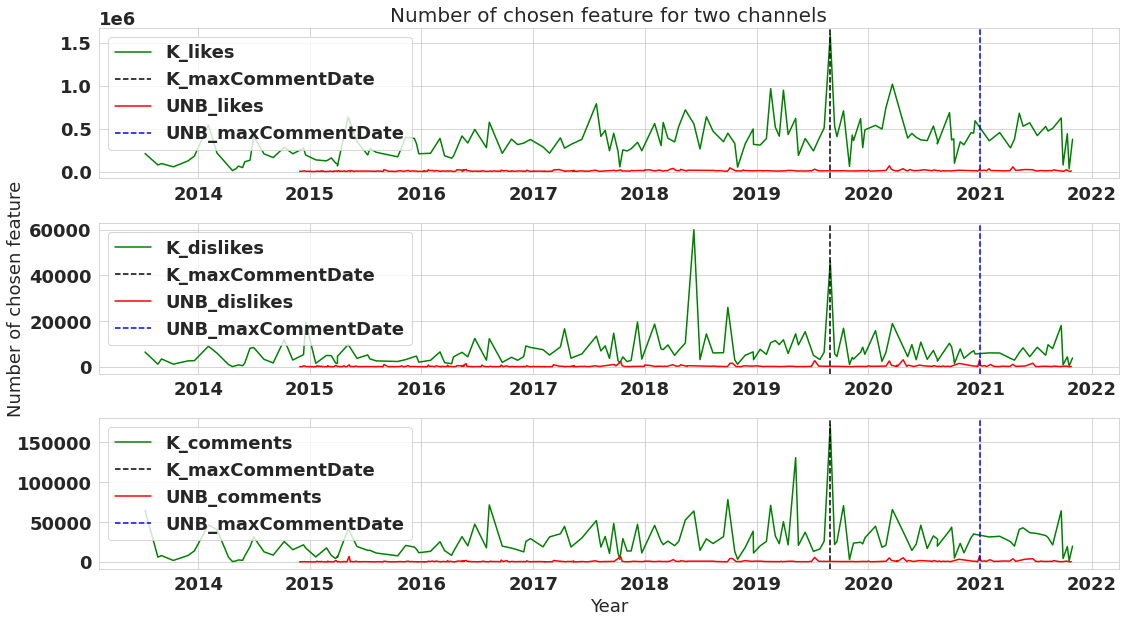

In [39]:
fig, axs = plt.subplots(3, 1)


# axs[0].plot(views['publishedDate'], views['views'], label = 'views')
# ax2 = ax1.twinx()
axs[0].plot(K_views['publishedDate'], K_views['liked'], label = 'K_likes', color='green')
axs[0].axvline(K_views['publishedDate'][46], color='black', label='K_maxCommentDate', linestyle='--')
axs[0].plot(UNB_views['publishedDate'], UNB_views['liked'], label = 'UNB_likes', color='red')
axs[0].axvline(UNB_views['publishedDate'][26], color='blue', label='UNB_maxCommentDate', linestyle='--')
axs[0].set_title('Number of chosen feature for two channels', fontsize=20)
axs[0].legend(loc=0)

axs[1].plot(K_views['publishedDate'], K_views['disliked'], label = 'K_dislikes', color='green')
axs[1].axvline(K_views['publishedDate'][46], color='black', label='K_maxCommentDate', linestyle='--')
axs[1].plot(UNB_views['publishedDate'], UNB_views['disliked'], label = 'UNB_dislikes', color='red')
axs[1].axvline(UNB_views['publishedDate'][26], color='blue', label='UNB_maxCommentDate', linestyle='--')
axs[1].legend(loc=0)

axs[2].plot(K_views['publishedDate'], K_views['comment'], label = 'K_comments', color='green')
axs[2].axvline(K_views['publishedDate'][46], color='black', label='K_maxCommentDate', linestyle='--')
axs[2].plot(UNB_views['publishedDate'], UNB_views['comment'], label = 'UNB_comments', color='red')
axs[2].axvline(UNB_views['publishedDate'][26], color='blue', label='UNB_maxCommentDate', linestyle='--')
axs[2].legend(loc=0)

axs[1].set_ylabel("Number of chosen feature")
plt.xlabel("Year")
# axs.grid()
plt.tight_layout()

### Publication frequency

In [40]:
K_years = K_df['publishedDate'].dt.year.unique()
K_years.sort()

UNB_years = UNB_df['publishedDate'].dt.year.unique()
UNB_years.sort()

In [41]:
K_videosPerYear = pd.DataFrame({'year': K_years, 'freq': K_df.groupby(K_df['publishedDate'].dt.year)['publishedDate'].count()}).reset_index(drop=True)
UNB_videosPerYear = pd.DataFrame({'year': UNB_years, 'freq': UNB_df.groupby(UNB_df['publishedDate'].dt.year)['publishedDate'].count()}).reset_index(drop=True)

Text(0, 0.5, 'Number of videos in year')

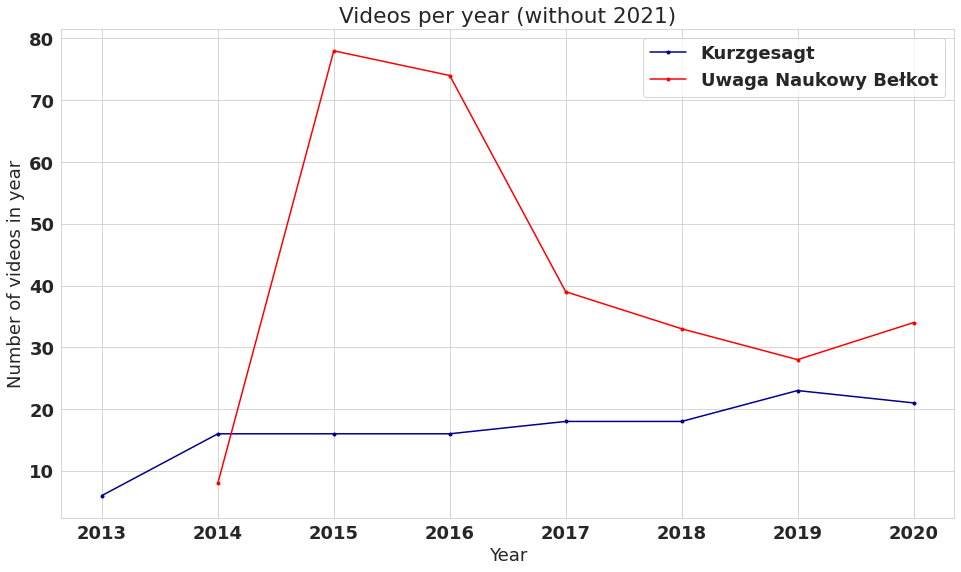

In [42]:
plt.plot(K_videosPerYear[:-1]['year'], K_videosPerYear[:-1]['freq'], '.-',color = 'darkblue', label = 'Kurzgesagt') # excluding 2021 - incomplete data
plt.plot(UNB_videosPerYear[:-1]['year'], UNB_videosPerYear[:-1]['freq'], '.-', color = 'red', label = 'Uwaga Naukowy Bełkot')
plt.legend()
plt.title("Videos per year (without 2021)")
plt.xlabel("Year")
plt.ylabel("Number of videos in year")

In [43]:
UNB_months = UNB_years = UNB_df['publishedDate'].dt.month.unique()
UNB_videoPerMonth = pd.DataFrame({'month': UNB_months, 'freq': UNB_df.groupby(UNB_df['publishedDate'].dt.month)['publishedDate'].count()}).reset_index(drop=True)
UNB_videoPerMonth = UNB_videoPerMonth.sort_values(by='month').reset_index(drop=True)

K_months = K_years = K_df['publishedDate'].dt.month.unique()
K_videoPerMonth = pd.DataFrame({'month': K_months, 'freq': K_df.groupby(K_df['publishedDate'].dt.month)['publishedDate'].count()}).reset_index(drop=True)
K_videoPerMonth = K_videoPerMonth.sort_values(by='month').reset_index(drop=True)

Text(0, 0.5, 'Number of videos in month')

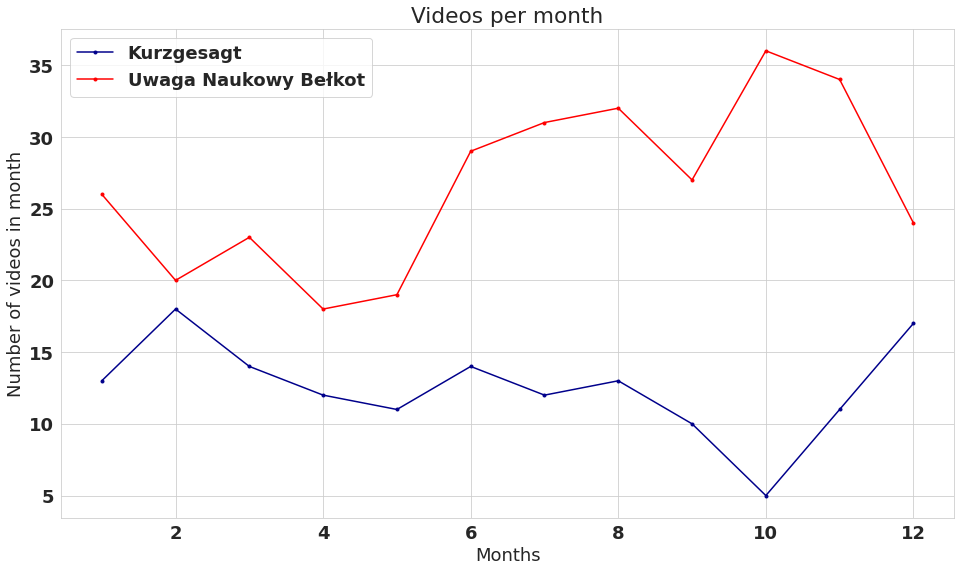

In [44]:
plt.plot(K_videoPerMonth['month'], K_videoPerMonth['freq'], '.-',color = 'darkblue', label = 'Kurzgesagt')
plt.plot(UNB_videoPerMonth['month'], UNB_videoPerMonth['freq'], '.-', color = 'red', label = 'Uwaga Naukowy Bełkot')
plt.legend()
plt.title("Videos per month")
plt.xlabel("Months")
plt.ylabel("Number of videos in month")

### Comments versus other featuries

In [45]:
UNB_dislikes = UNB_views['disliked']
UNB_likes = UNB_views['liked']
UNB_comments = UNB_views['comment']

K_dislikes = K_views['disliked']
K_likes = K_views['liked']
K_comments = K_views['comment']

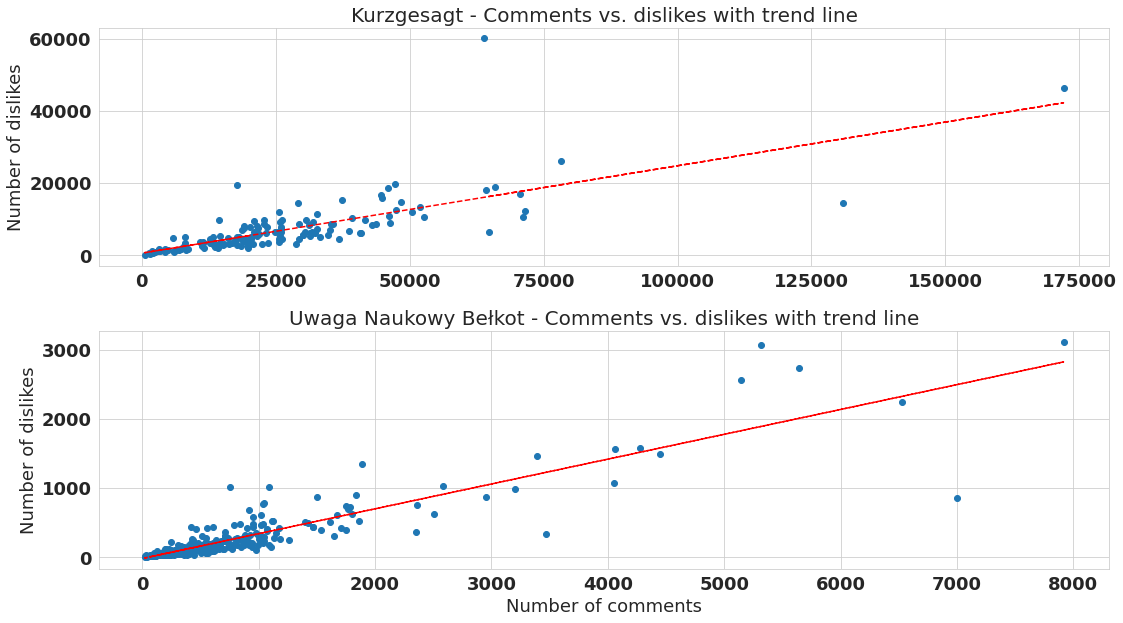

In [46]:
fig, axs = plt.subplots(2, 1)
K_z = np.polyfit(K_comments, K_dislikes, 1)
K_p = np.poly1d(K_z)

UNB_z = np.polyfit(UNB_comments, UNB_dislikes, 1)
UNB_p = np.poly1d(UNB_z)

#plt.figure(figsize=(16, 7))
axs[0].scatter(K_comments, K_dislikes)
axs[0].plot(K_comments,K_p(K_comments),"r--")
axs[0].set_title('Kurzgesagt - Comments vs. dislikes with trend line', fontsize=20)
axs[0].set_ylabel("Number of dislikes")

axs[1].scatter(UNB_comments, UNB_dislikes)
axs[1].plot(UNB_comments,UNB_p(UNB_comments),"r--")
axs[1].set_title('Uwaga Naukowy Bełkot - Comments vs. dislikes with trend line', fontsize=20)
axs[1].set_ylabel("Number of dislikes")

#plt.title("Comments vs. dislikes with trend line")
plt.xlabel("Number of comments")
#plt.ylabel("Number of dislikes")
plt.tight_layout()

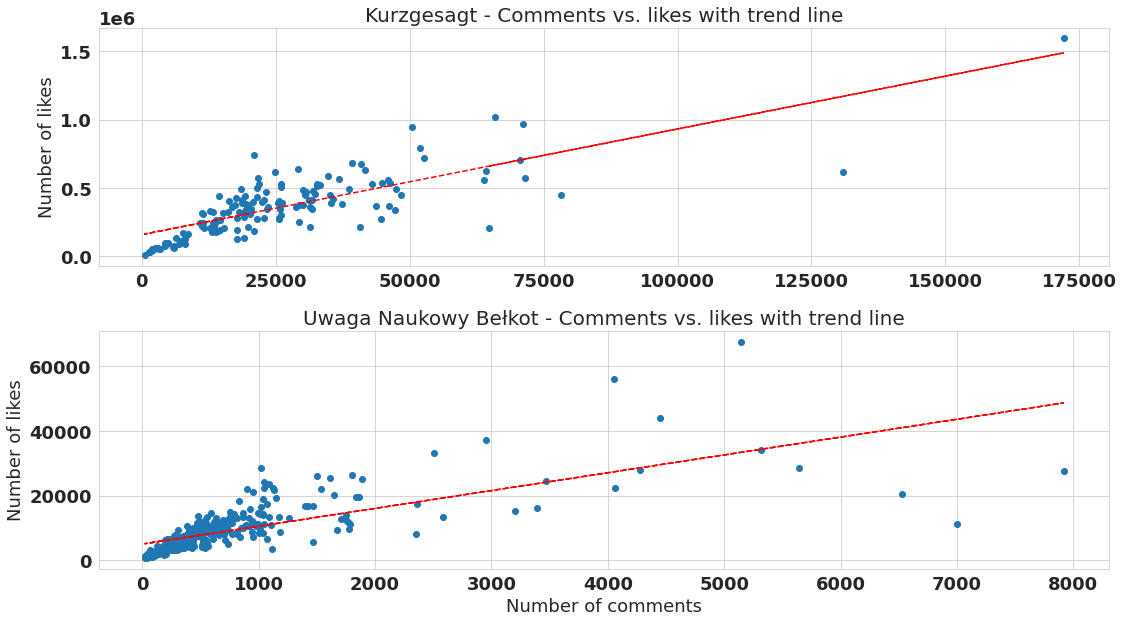

In [47]:
fig, axs = plt.subplots(2, 1)
K_z = np.polyfit(K_comments, K_likes, 1)
K_p = np.poly1d(K_z)

UNB_z = np.polyfit(UNB_comments, UNB_likes, 1)
UNB_p = np.poly1d(UNB_z)


axs[0].scatter(K_comments, K_likes)
axs[0].plot(K_comments,K_p(K_comments),"r--")
axs[0].set_title('Kurzgesagt - Comments vs. likes with trend line', fontsize=20)
axs[0].set_ylabel("Number of likes")

axs[1].scatter(UNB_comments, UNB_likes)
axs[1].plot(UNB_comments,UNB_p(UNB_comments),"r--")
axs[1].set_title('Uwaga Naukowy Bełkot - Comments vs. likes with trend line', fontsize=20)
axs[1].set_ylabel("Number of likes")


plt.xlabel("Number of comments")
plt.tight_layout()

In [48]:
UNB_viewsWithoutOutliers = UNB_views[UNB_views['liked'] != UNB_views['liked'].max()].reset_index(drop=True)
UNB_viewsWithoutOutliers = UNB_viewsWithoutOutliers[UNB_viewsWithoutOutliers['comment'] != UNB_viewsWithoutOutliers['comment'].max()]

K_viewsWithoutOutliers = K_views[K_views['liked'] != K_views['liked'].max()].reset_index(drop=True)
K_viewsWithoutOutliers = K_viewsWithoutOutliers[K_viewsWithoutOutliers['comment'] != K_viewsWithoutOutliers['comment'].max()]

In [49]:
K_likesWithoutOutlier = K_viewsWithoutOutliers['liked']
K_commentsWithoutOutlier = K_viewsWithoutOutliers['comment']

UNB_likesWithoutOutlier = UNB_viewsWithoutOutliers['liked']
UNB_commentsWithoutOutlier = UNB_viewsWithoutOutliers['comment']

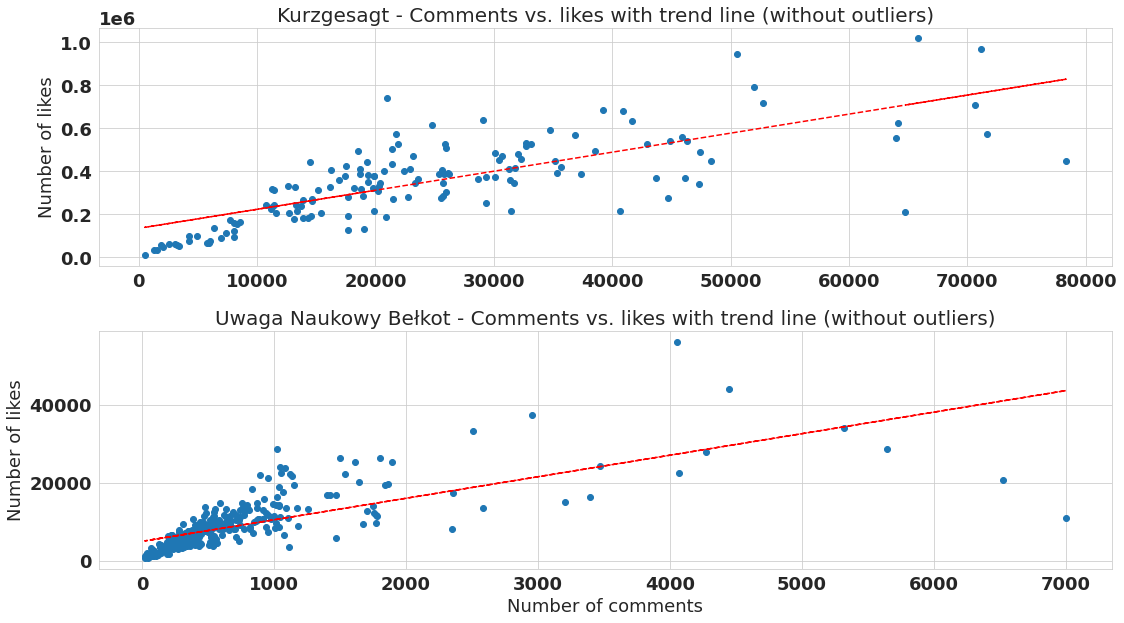

In [50]:
fig, axs = plt.subplots(2, 1)

UNB_function_wo = np.polyfit(UNB_commentsWithoutOutlier, UNB_likesWithoutOutlier, 1)
UNB_f = np.poly1d(UNB_function_wo)

K_function_wo = np.polyfit(K_commentsWithoutOutlier, K_likesWithoutOutlier, 1)
K_f = np.poly1d(K_function_wo)


axs[0].scatter(K_commentsWithoutOutlier, K_likesWithoutOutlier)
axs[0].plot(K_commentsWithoutOutlier,K_f(K_commentsWithoutOutlier),"r--")
axs[0].set_title('Kurzgesagt - Comments vs. likes with trend line (without outliers)', fontsize=20)
axs[0].set_ylabel("Number of likes")

axs[1].scatter(UNB_commentsWithoutOutlier, UNB_likesWithoutOutlier)
axs[1].plot(UNB_commentsWithoutOutlier,UNB_f(UNB_commentsWithoutOutlier),"r--")
axs[1].set_title('Uwaga Naukowy Bełkot - Comments vs. likes with trend line (without outliers)', fontsize=20)
axs[1].set_ylabel("Number of likes")


plt.xlabel("Number of comments")
plt.tight_layout()

In [51]:
pd.set_option('display.max_colwidth', None)
UNB_mostViewedVideos = UNB_df[['title',
                       'publishedDate',
                       'views']].sort_values(by='views', ascending=False).reset_index(drop=True)
UNB_mostViewedVideos.head(5)

,title,publishedDate,views
0,Czy koronawirus może zniszczyć ludzkość?,2020-03-09 17:48:32,2000184
1,Czarnobyl - 30 lat nowego myślenia. Część 2: Walka ze śmiercią,2016-04-28 17:04:22,1339866
2,6 najbardziej niemoralnych eksperymentów na ludziach | Ranking Naukowego Bełkotu #09,2016-01-23 15:09:28,1318754
3,Autyzm - piękniejszy umysł,2018-04-02 14:50:54,1155827
4,Czarnobyl - 30 lat nowego myślenia. Część 1: Test.,2016-04-25 18:13:39,1122589


In [52]:
pd.set_option('display.max_colwidth', None)
K_mostViewedVideos = K_df[['title',
                       'publishedDate',
                       'views']].sort_values(by='views', ascending=False).reset_index(drop=True)
K_mostViewedVideos.head(5)

,title,publishedDate,views
0,The Coronavirus Explained & What You Should Do,2020-03-19 15:21:54,35605875
1,What If You Detonated a Nuclear Bomb In The Marianas Trench? (Science not Fantasy),2018-07-20 13:04:48,28957478
2,The Fermi Paradox — Where Are All The Aliens? (1/2),2015-05-06 12:23:08,27958615
3,The Deadliest Being on Planet Earth – The Bacteriophage,2018-05-12 18:13:11,27525342
4,The Immune System Explained I – Bacteria Infection,2014-07-01 15:42:18,26219952


### Analysis of the duration of the videos

In [53]:
pd.reset_option('display.max_colwidth')

<Figure size 1152x648 with 0 Axes>

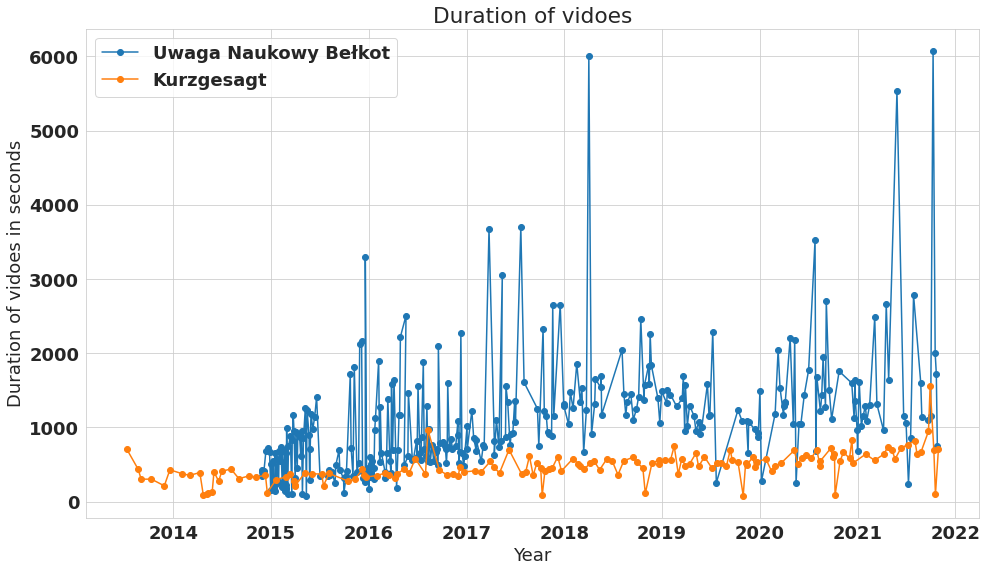

In [54]:
plt.clf()
fig, ax1 = plt.subplots()


ax1.plot(UNB_views['publishedDate'], UNB_views['duration_in_sec'],'-o', label = 'Uwaga Naukowy Bełkot')
ax1.plot(K_views['publishedDate'], K_views['duration_in_sec'],'-o', label = 'Kurzgesagt')
ax1.set_xlabel('Year')
ax1.set_ylabel('Duration of vidoes in seconds')
ax1.set_title('Duration of vidoes')
ax1.legend()

##  Analysis of two videos on similar topics

In [55]:
UNB_content = youtube.videos().list(part="snippet,contentDetails,statistics",id='Omm_KaIY6_0').execute()
K_content = youtube.videos().list(part="snippet,contentDetails,statistics",id='hOfRN0KihOU').execute()

In [56]:
UNB_df[['title', 
    'publishedDate', 
    'views', 
    'liked', 
    'disliked', 
    'duration', 
    'video_definition', 
    'is_caption']][UNB_df['videoid']=='Omm_KaIY6_0'].reset_index(drop=True)

,title,publishedDate,views,liked,disliked,duration,video_definition,is_caption
0,5 dowodów ewolucji na naszych oczach,2017-09-27 17:52:20,223974,8071,357,00:12:34,hd,false


In [57]:
K_df[['title', 
    'publishedDate', 
    'views', 
    'liked', 
    'disliked', 
    'duration', 
    'video_definition', 
    'is_caption']][K_df['videoid']=='hOfRN0KihOU'].reset_index(drop=True)

,title,publishedDate,views,liked,disliked,duration,video_definition,is_caption
0,How Evolution works,2013-07-11 13:38:44,9331298,210461,6452,00:11:48,hd,true


### Comment sentiments

In [58]:
UNB_video_id='Omm_KaIY6_0'
UNB_kwargs = {"part":'snippet', "videoId":UNB_video_id, "textFormat":'plainText'}
UNB_results  = youtube.commentThreads().list(**UNB_kwargs).execute()

K_video_id='hOfRN0KihOU'
K_kwargs = {"part":'snippet', "videoId":K_video_id, "textFormat":'plainText'}
K_results  = youtube.commentThreads().list(**K_kwargs).execute()

In [59]:
UNB_comments = []
while UNB_results:
    for item in UNB_results['items']:
        UNB_comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
        UNB_comments.append(UNB_comment)

    if 'nextPageToken' in UNB_results:
        UNB_kwargs['pageToken'] = UNB_results['nextPageToken']
        UNB_results = youtube.commentThreads().list(**UNB_kwargs).execute()
    else:
        break

In [60]:
K_comments = []
while K_results:
    for item in K_results['items']:
        K_comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
        K_comments.append(K_comment)

    if 'nextPageToken' in K_results:
        K_kwargs['pageToken'] = K_results['nextPageToken']
        K_results = youtube.commentThreads().list(**K_kwargs).execute()
    else:
        break

In [61]:
UNB_comments 

['Ja byłem tutaj.\nI was here.',
 'Ja byłem tutaj.',
 'Większych bzdur nie słyszałem - różnorodność na potwierdzenie ewolucji. Zanim zajmiesz się jakimś tematem radzę przeczytać definicję a następnie ją zrozumieć a nie powielać brednie. Zmiany wewnątrz gatunku to nie ewolucja a przystosowanie, dopóki osobniki mogą się krzyżować i  mieć potomstwo to jest to ten sam gatunek - tak stanowi teoria ewolucji. Jakby ktoś znalazł chociaż 1 słownie jeden dowód na ewolucję usłyszelibyśmy o tym we wszystkich serwisach informacyjnych a tylko mamy ktoś coś gdzieś, żadnego potwierdzonego przypadku. O latimerii słyszałeś ta taka ryba, która miała być 100 % dowodem - wyszła z wody tylko ktoś zapomniał jej o tym powiedzieć.',
 'od kiedy krzyżowanie się gatunków jest ewolucją ?? w wyniku mutacji  traci sie pewne wlasciwosci  i przez to zyskuje inne ..to nie jest ewolucja.. jaszczurka ,mrowka i motyl dowodem ewolucji homo sapiens ..hmmm',
 'Gdzie tu jakieś dowody?! Wyjaśniasz tylko że ewolucja jest w odrę

In [62]:
K_comments

['You want to learn more about science? Check out our sciency products on the kurzgesagt shop – all designed with love and produced with care. \nGetting something from the kurzgesagt shop is the best way to support us and to keep our videos free for everyone. \n►► http://kgs.link/science\n(Worldwide Shipping Available)',
 "WHY SPEND TIME LEARNING SCIENCE\nWHEN YOU CAN STAY AN IGNORANT MAGIC BELIEVING CREATARD?\nWHO DOESN'T LOVE MAGIC FAIRY TALES?",
 'Dude his voice didnt even change a bit',
 'THE PROFOUND RICHNESS of the hyper-precise information that took us from microbes to Michelangelo came from random damage to the information in the DNA with comatose natural selection (a slave to an undirected process) conveniently culling it all out like seeds in a cotton gin.  And whales can fly.                  Stay healthy everyone.',
 'Supporters of the theory give new meaning to the word "optimistic"',
 'This is what i needed. Thank you Subscribe ❤',
 'MY CHRISTIAN RAGE IS FUELED BY IGNORAN

In [63]:
negative_dict_pl = ['bzdury', 'bzdurny', 'bzdura', 'głupi', 'głupie', 'słaby', 'słabe', 'ignoranci', 'bezwartościowy'
                   ,'Oszalałeś', 'regres', 'rak', 'raka', 'brednie']
positivie_dict_pl = ['świetny', 'świetnie', 'Świetne', 'dobry', 'dobrze', 'dzięki', 'Dzięki', 'Dziękuję', 'Dobra robota', 'ciekawy', 'ciekawie', 'Super', 'super',
                    'jaram się', 'mądre', 'mądry', 'cieszę się', 'interesująco']

negative_dict_eng = ['Nonsense', 'nonsense', 'stupid', 'Stupid', 'weak', 'Weak', 'Ignorant', 'ignorant', 'worthless'
                    , 'Worthless', 'You are mad', 'regress', 'Cancer', 'cancer', 'nonsense', 'nonsense', 'boolsheet', 'boolshit', 'amazing', 'Amazing',
                    'sucks']
positivie_dict_eng = ['cute', 'Cute', 'CUTE', 'Great', 'great', 'GREAT', 'Good', 'good', 'fine', 'Thanks',' thanks', 'thank you',
                      'well done', 'Interesting', 'interesting', 'Well done','Cool','COOL', ' cool','smart' 'smart', 'wise', 
                       'interesting', 'Interesting']

In [64]:
sentiments = []
l =[]
for com in UNB_comments:
    feedback = 0
    for w in negative_dict_pl :
        if w in com:
            feedback -= 1
    for w in positivie_dict_pl :
        if w in com:
            feedback += 1
    sentiments.append(feedback)
    l.append(len(com))

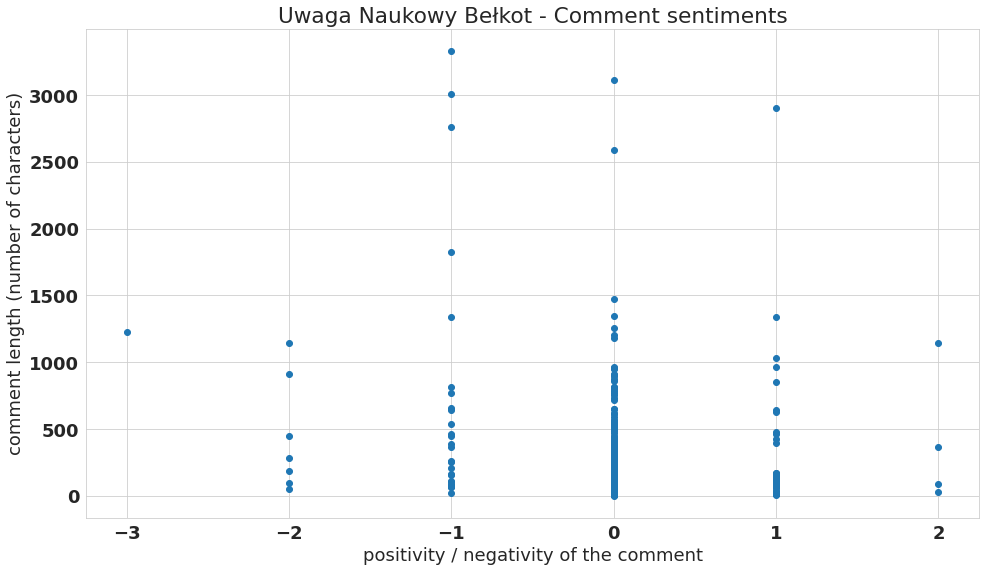

In [65]:
plt.plot(sentiments, l, 'o')
plt.xlabel('positivity / negativity of the comment')
plt.ylabel('comment length (number of characters)')
plt.title('Uwaga Naukowy Bełkot - Comment sentiments')
plt.show()

In [66]:
K_sentiments = []
K_l =[]
for com in K_comments:
    feedback = 0
    for w in negative_dict_eng :
        if w in com:
            feedback -= 1
    for w in positivie_dict_eng :
        if w in com:
            feedback += 1
    K_sentiments.append(feedback)
    K_l.append(len(com))

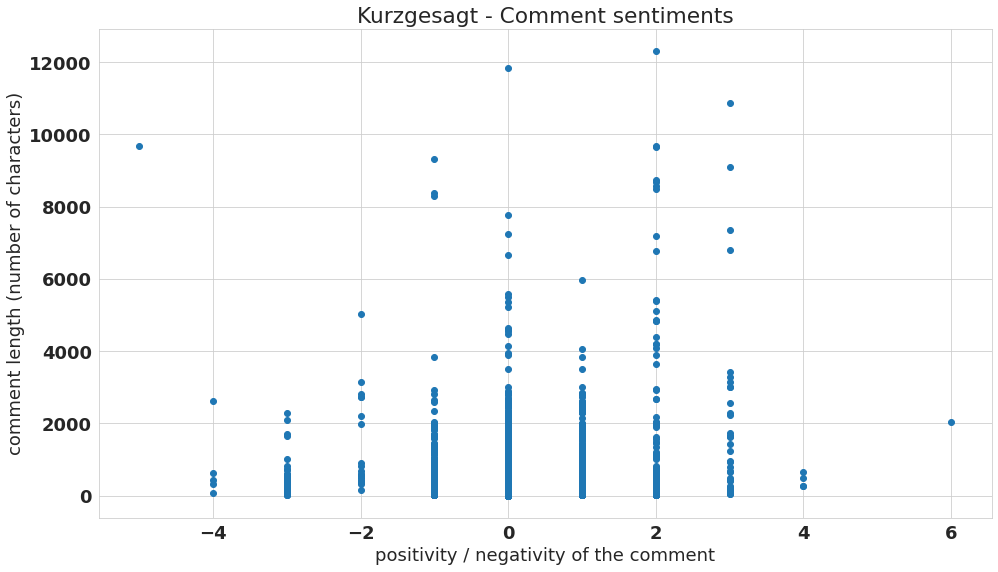

In [67]:
plt.plot(K_sentiments, K_l, 'o')
plt.xlabel('positivity / negativity of the comment')
plt.ylabel('comment length (number of characters)')
plt.title('Kurzgesagt - Comment sentiments')
plt.show()

### Compare_the_tags_of_both_videos

In [68]:
K_tags = (K_content['items'])[0]['snippet']['tags']
K_tags

['evolution',
 'science',
 'darwin',
 'design',
 'infographic',
 'dawkins',
 'Intelligent',
 'biology',
 'explain',
 'learning',
 'animation',
 'Creationism',
 'Erklärfilm',
 'kurzeng',
 'documentaries',
 'youtube',
 'funny']

In [69]:
(UNB_content['items'])[0]['snippet']['tags']

['uwaga',
 'naukowy',
 'bełkot',
 'popularnonaukowe',
 'ciekawostki',
 'nauka',
 'wiedza',
 'biologia',
 'ewolucja',
 'geny',
 'chemia',
 'dobór',
 'naturalny',
 'darwinizm',
 'rankin',
 'naukowego',
 'bełkotu',
 'dowody',
 'zięba',
 'darwina',
 'ciernik',
 'zoqua',
 'molinezja',
 'mysz',
 'warfaryna',
 'pluskwa',
 'moyl',
 'wolbachia',
 'jaszczurka',
 'murówka',
 'sycylijska']

In [70]:
UNB_tags = ['Attention','scientific','babble','popular science','Interesting facts','science','knowledge','biology','evolution','genes',
  'chemistry','selection','natural','Darwinism','rankin','scientific','gibberish','evidence','finch','Darwin''stickleback','zoqua','molynesia','mouse',
  'warfarin','bug','moyl','wolbachia','lizard','murówka',
  'Sicilian']

In [71]:
same_tags = []
for tag in UNB_tags:
    for t in K_tags:
        if tag == t:
            same_tags.append(tag)

In [72]:
same_tags

['science', 'biology', 'evolution']

## Summary
For our analysis, we decided to choose two popular science channels, both of them are considered very factual and reliable in the YouTube community. From the analyzes, we can conclude that the popularity of scientific channels has remained very stable for years, including small drops and increases from time to time. The channel of various sizes was analyzed, both in terms of subscriptions and views. However, despite this difference, we can observe similar trends in terms of popularity or reception by viewers. For the study of individual videos, we chose those related to evolutionism, similar content allowed us to better compare the overtones of the videos. By analyzing the comments, we can conclude that viewers of scientific channels rarely express extremely negative opinions and their statements are often very extensive. Such a result agrees with the intuition that viewers of these channels often prefer to refer to scientific theory in the film and substantively express their opinion, rather than expressing negative / positive opinions about, for example, other users.